In [44]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid")
sns.set_theme(style="ticks")
sns.set_context("talk")

In [45]:
# CAA was reconstituted in 400uL instead of 500uL
# CAA peak will then be 5/4 times what it should be
## RR will then be 4/5 of what it should be
# Correction factor: 5/4

def RR2Asp(RR):
    return(54.611* ((RR * 5/4)**1.0578))
def RR2Asn(RR):
    return(60.033* ((RR * 5/4)**0.9177))

In [59]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp-levels-post-depletion_2xGOT-KO.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Flag Details'], axis=1)

In [60]:
metab_dict_mes['Uridine neg']

Compound    RT Sample ID      Response    Formula  Response Ratio  \
0   Uridine neg  6.22      AL01  1.822353e+11  C9H12N2O6               0   
1   Uridine neg  6.22      AL02  1.637095e+11  C9H12N2O6               0   
2   Uridine neg  6.22      AL03  1.679924e+11  C9H12N2O6               0   
3   Uridine neg  6.22      AL04  1.558694e+11  C9H12N2O6               0   
4   Uridine neg  6.22      AL05  1.521827e+11  C9H12N2O6               0   
5   Uridine neg  6.22      AL06  1.320242e+11  C9H12N2O6               0   
6   Uridine neg  6.22      AL07  1.327516e+11  C9H12N2O6               0   
7   Uridine neg  6.22      AL08  1.313303e+11  C9H12N2O6               0   
8   Uridine neg  6.22      AL09  1.156343e+11  C9H12N2O6               0   
9   Uridine neg  6.22      AL10  1.124997e+11  C9H12N2O6               0   
10  Uridine neg  6.22      AL11  9.301696e+10  C9H12N2O6               0   
11  Uridine neg  6.22      AL12  1.031553e+11  C9H12N2O6               0   
12  Uridine neg  6.22      AL13  1.221517e+11  C9H12N2O6               0   
13  Uridine neg  6.22      AL14  1.122964e+11  C9H12N2O6               0   
14  Uridine neg  6.22      AL15  1.214586e+11  C9H12N2O6               0   
15  Uridine neg  6.22      AL16  1.077504e+11  C9H12N2O6               0   
16  Uridine neg  6.22      AL17  1.106956e+11  C9H12N2O6               0   
17  Uridine neg  6.22      AL18  9.659187e+10  C9H12N2O6               0   
18  Uridine neg  6.22      AL19  9.891069e+10  C9H12N2O6               0   
19  Uridine neg  6.22      AL20  9.666598e+10  C9H12N2O6               0   
20  Uridine neg  6.22      AL21  8.810100e+10  C9H12N2O6               0   
21  Uridine neg  6.22      AL22  1.019777e+11  C9H12N2O6               0   
22  Uridine neg  6.22      AL23  9.731374e+10  C9H12N2O6               0   
23  Uridine neg  6.22      AL24  1.107244e+11  C9H12N2O6               0   
24  Uridine neg  6.22      AL25  1.831517e+09  C9H12N2O6               0   
25  Uridine neg  6.22      AL26  1.889975e+09  C9H12N2O6               0   
26  Uridine neg  6.22      AL27  1.832037e+09  C9H12N2O6               0   
27  Uridine neg  6.22      AL28  1.644366e+09  C9H12N2O6               0   

   Sample_name  Dilution_factor       Drug Sample_type  Time  Cell_vol  \
0         AL01         0.005999    Vehicle       Cells     0  0.431762   
1         AL02         0.005999    Vehicle       Cells     0  0.431762   
2         AL03         0.005999  1uM-GCN2i       Cells     0  0.418052   
3         AL04         0.005999  1uM-GCN2i       Cells     0  0.418052   
4         AL05         0.007110    Vehicle       Cells     2  0.505235   
5         AL06         0.007110    Vehicle       Cells     2  0.505235   
6         AL07         0.007110  1uM-GCN2i       Cells     2  0.502042   
7         AL08         0.007110  1uM-GCN2i       Cells     2  0.502042   
8         AL09         0.007984    Vehicle       Cells     6  0.587800   
9         AL10         0.007984    Vehicle       Cells     6  0.587800   
10        AL11         0.007984  1uM-GCN2i       Cells     6  0.543275   
11        AL12         0.007984  1uM-GCN2i       Cells     6  0.543275   
12        AL13         0.007920    Vehicle       Cells    10  0.580085   
13        AL14         0.007920    Vehicle       Cells    10  0.580085   
14        AL15         0.007920  1uM-GCN2i       Cells    10  0.541903   
15        AL16         0.007920  1uM-GCN2i       Cells    10  0.541903   
16        AL17         0.008821    Vehicle       Cells    14  0.613584   
17        AL18         0.008821    Vehicle       Cells    14  0.613584   
18        AL19         0.008821  1uM-GCN2i       Cells    14  0.636112   
19        AL20         0.008821  1uM-GCN2i       Cells    14  0.636112   
20        AL21         0.008082    Vehicle       Cells    26  0.562484   
21        AL22         0.008082    Vehicle       Cells    26  0.562484   
22        AL23         0.008082  1uM-GCN2i       Cells    26  0.582534   
23        AL24         0.0

In [61]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
        df['Aspartate conc'] = df['Aspartate conc'].replace(np.nan, 0)

In [62]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

df['ATP-ADP'] = (df['ATP pos'] / df['ADP pos']).replace(np.inf, np.nan)
df['ATP-AMP'] = (df['ATP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['ADP-AMP'] = (df['ADP pos'] / df['AMP pos']).replace(np.inf, np.nan)

df['UTP-UDP'] = (df['UTP neg'] / df['UDP neg']).replace(np.inf, np.nan)
df['UTP-UMP'] = (df['UTP neg'] / df['UMP neg']).replace(np.inf, np.nan)
df['UDP-UMP'] = (df['UDP neg'] / df['UMP neg']).replace(np.inf, np.nan)




In [94]:
mask = (df['Sample_type'] == 'Cells')
cv = df[mask]['Cell_vol'].values
t = df[mask]['Time'].values
prof = (np.log2(cv[4:]) - np.log2(np.mean(cv[:4]))) / t[4:]
prof = prof / np.mean(prof[0:4])
prof = np.concatenate([np.zeros(4), prof, np.zeros(4)])
df['prof'] = prof

In [95]:
df_mean = df.groupby(['Time', 'Sample_type']).mean().reset_index()
df_stdev = df.groupby(['Time', 'Sample_type']).std().reset_index()

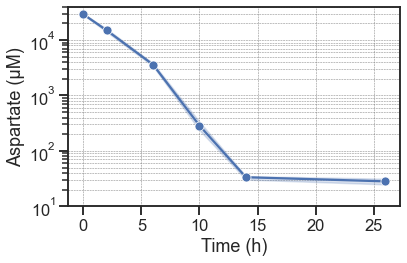

In [10]:
### Aspartate as a function of time ###

pdf = matplotlib.backends.backend_pdf.PdfPages('Asp_vs_time.pdf')
fig = plt.figure(figsize=(6, 4))

mask = (df['Sample_type'] == 'Cells')
g = sns.lineplot(data=df[mask], x='Time', y='Aspartate conc', markers=True, marker="o")
g.set(yscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.yaxis.set_minor_locator(locmin)
g.yaxis.set_minor_formatter(mticker.NullFormatter())
g.set(ylim=(10, 40000))

g.set(ylabel='Aspartate (μM)', xlabel='Time (h)')



plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

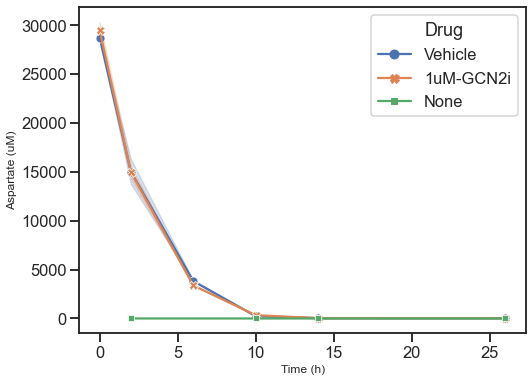

In [11]:
### Aspartate as a function of time ###

pdf = matplotlib.backends.backend_pdf.PdfPages('Asp_vs_time-media.pdf')
fig = plt.figure(figsize=(8, 6))

g = sns.lineplot(data=df, x='Time', y='Aspartate conc', hue='Drug',
             style='Drug', markers=True, dashes=False)
#g.set(yscale="log");

plt.xlabel('Time (h)', size=12);
plt.ylabel('Aspartate (uM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

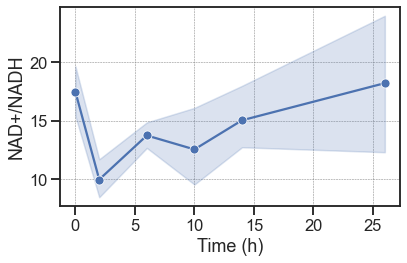

In [12]:
### Aspartate as a function of time ###

#pdf = matplotlib.backends.backend_pdf.PdfPages('Asp_vs_time.pdf')
fig = plt.figure(figsize=(6, 4))

mask = (df['Sample_type'] == 'Cells')
g = sns.lineplot(data=df[mask], x='Time', y='NAD-NADH', markers=True, marker="o")
#g.set(yscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
#g.set(ylim=(10, 40000))

g.set(ylabel='NAD+/NADH', xlabel='Time (h)')



plt.tight_layout()

#pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
#pdf.close()

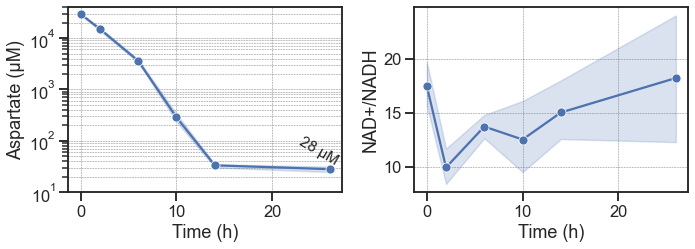

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.8))

mask = (df['Sample_type'] == 'Cells')
g1 = sns.lineplot(ax=ax1, data=df[mask], x='Time', y='Aspartate conc', markers=True, marker="o")
g1.set(yscale="log");


g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g1.yaxis.set_minor_locator(locmin)
g1.yaxis.set_minor_formatter(mticker.NullFormatter())
g1.set(ylim=(10, 40000))

g1.set(ylabel='Aspartate (μM)', xlabel='Time (h)')
asp_26h = round(np.mean(df[mask & (df['Time'] == 26)]['Aspartate conc'].values))
#g1.text(29.7, 19, '{} μM'.format(asp_26h), horizontalalignment='center', fontsize=15, rotation=0, backgroundcolor='white')
g1.text(24.8, 34, '{} μM'.format(asp_26h), horizontalalignment='center', fontsize=15, rotation=-30)



g2 = sns.lineplot(ax=ax2, data=df[mask], x='Time', y='NAD-NADH', markers=True, marker="o")
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g2.set(ylabel='NAD+/NADH', xlabel='Time (h)')




plt.tight_layout()
fig.savefig('combined_plots_Asp-NAD.pdf')

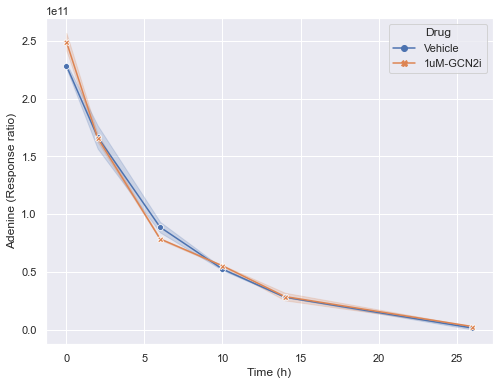

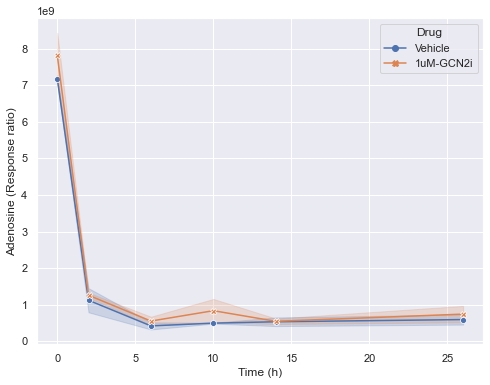

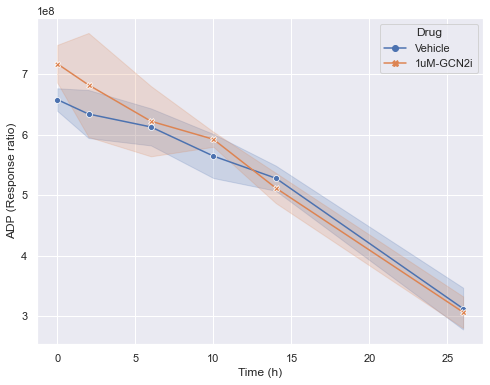

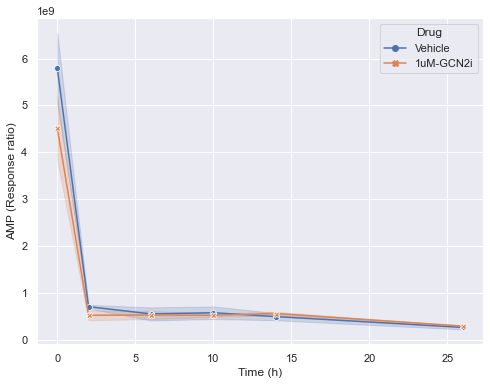

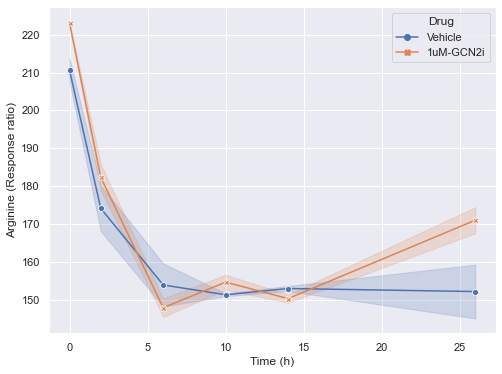

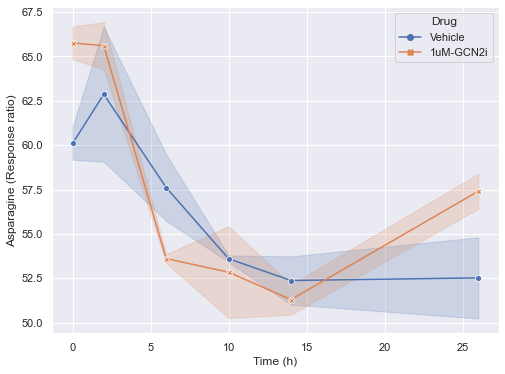

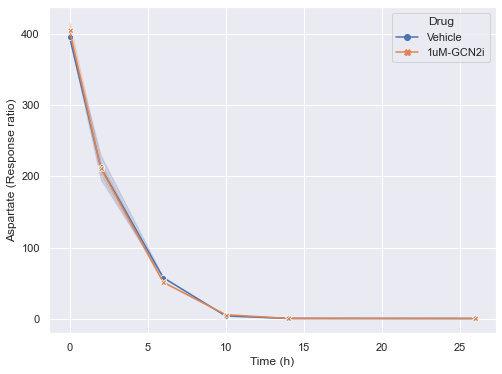

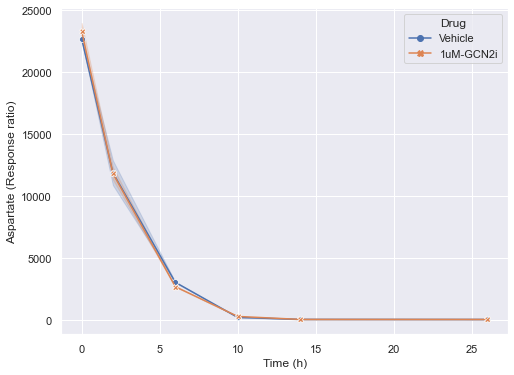

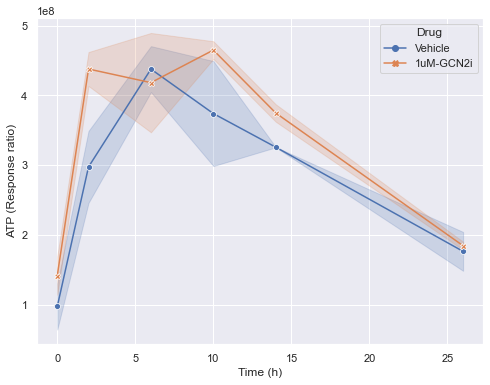

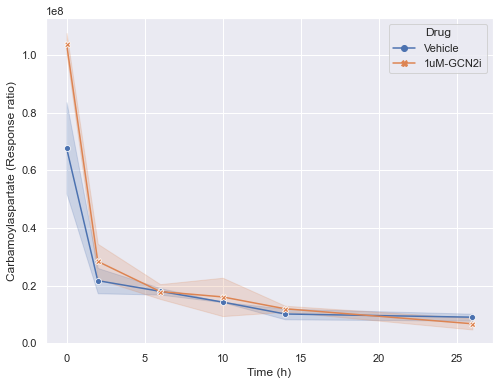

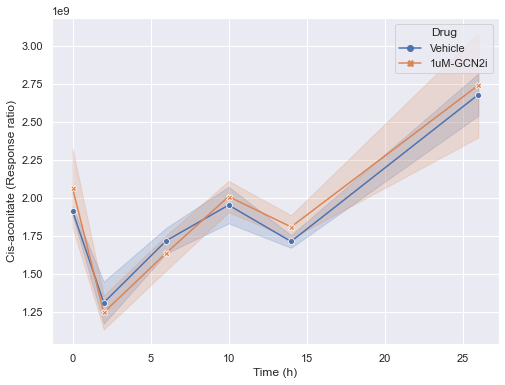

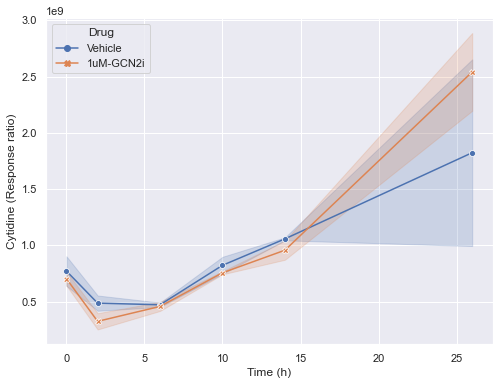

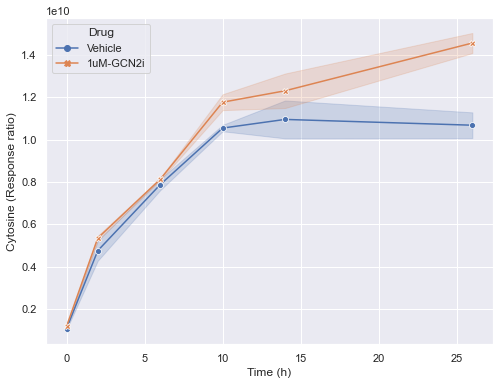

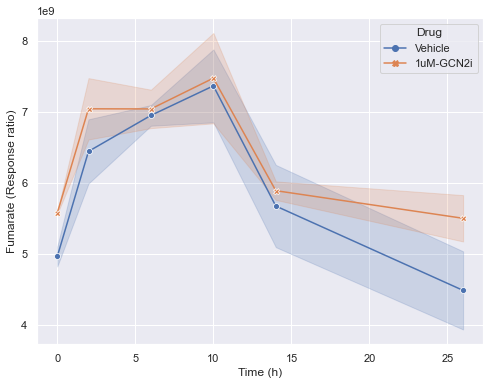

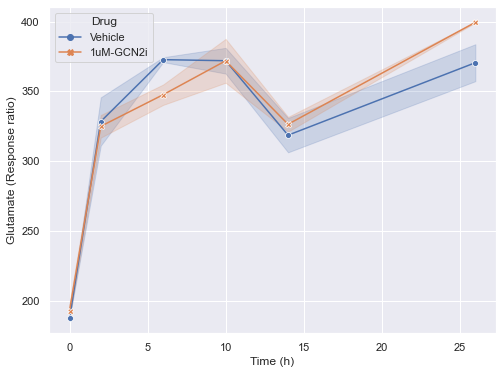

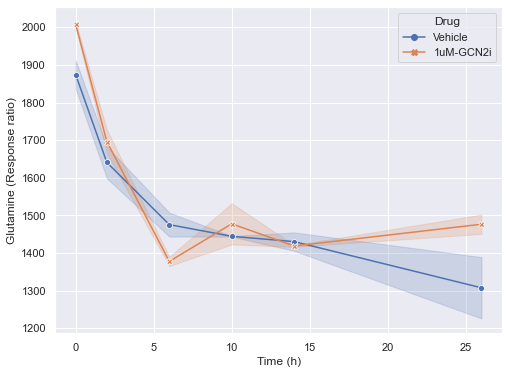

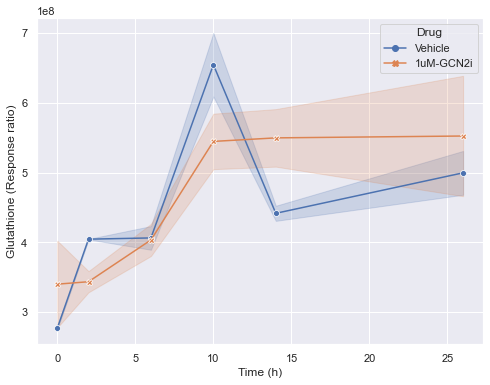

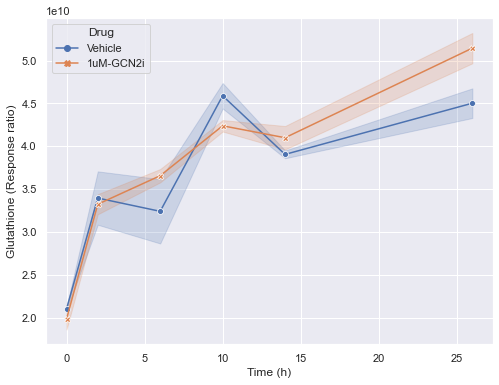

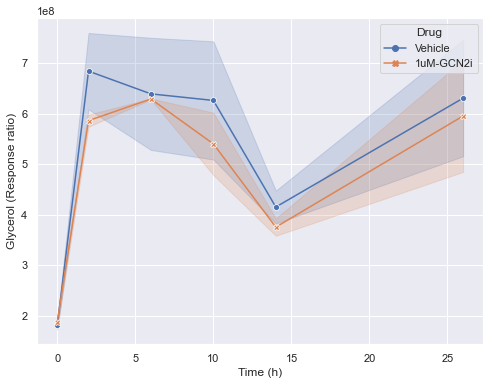

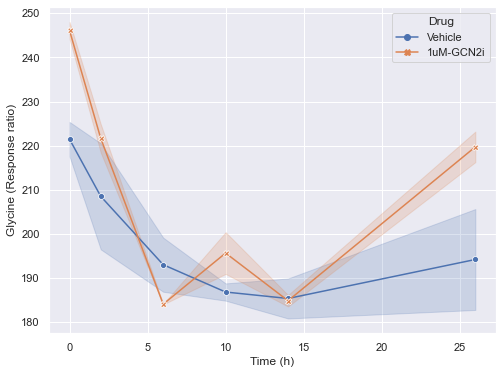

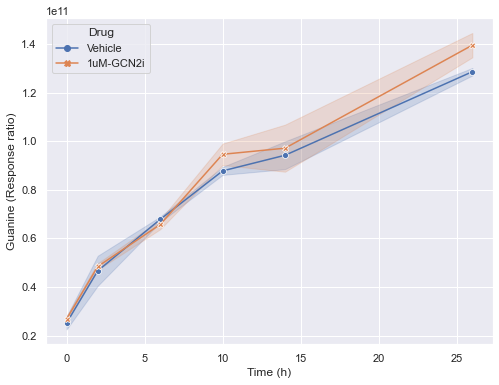

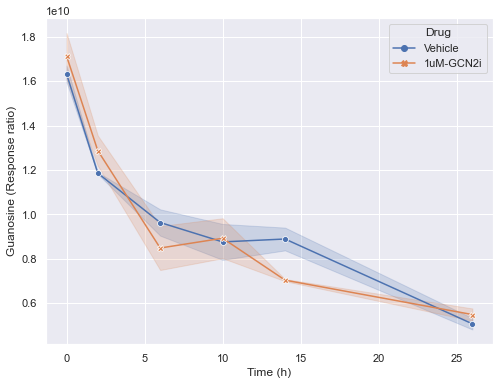

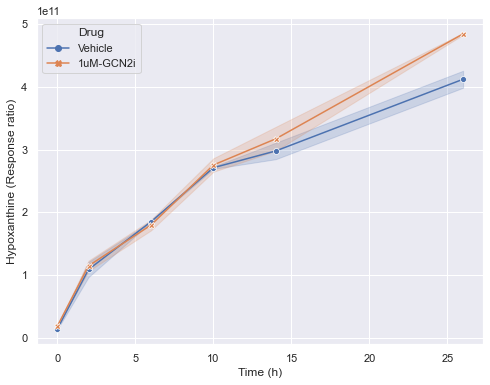

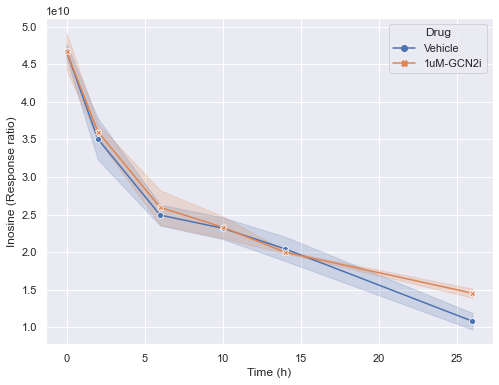

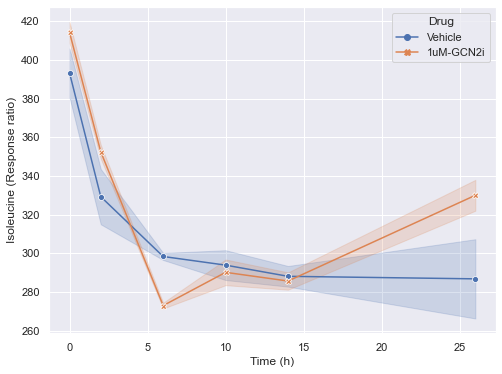

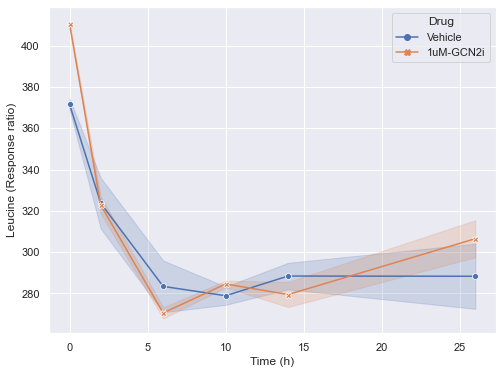

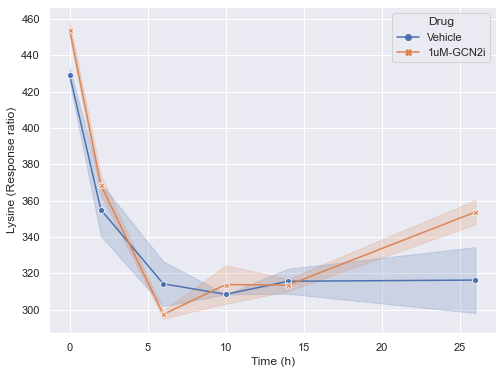

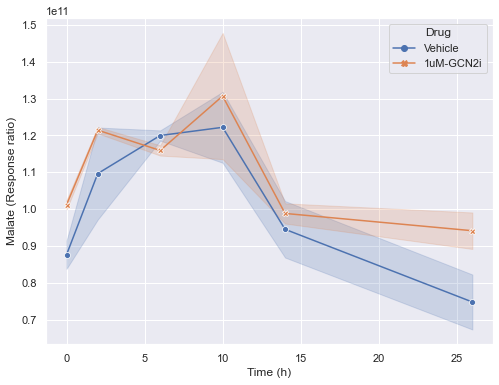

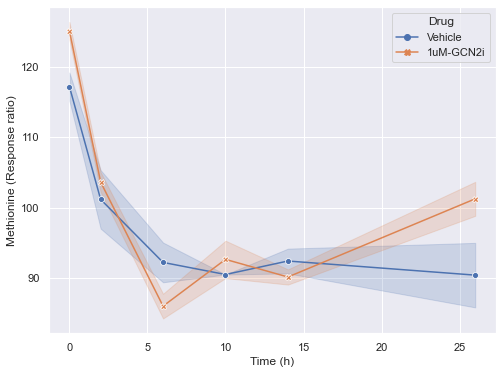

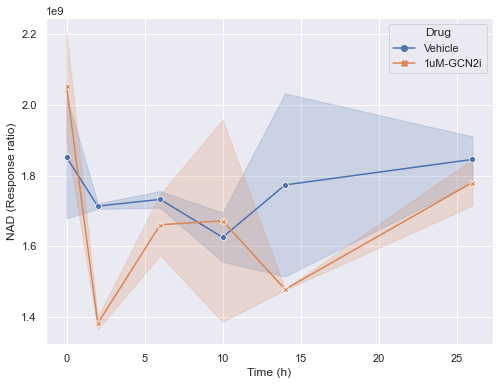

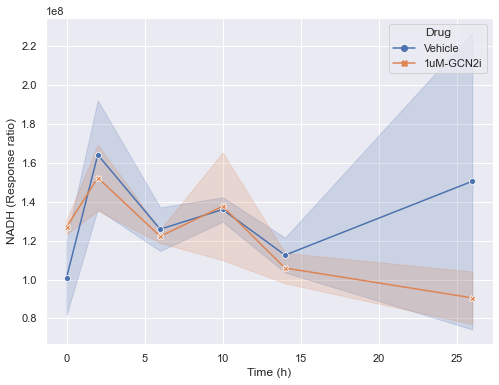

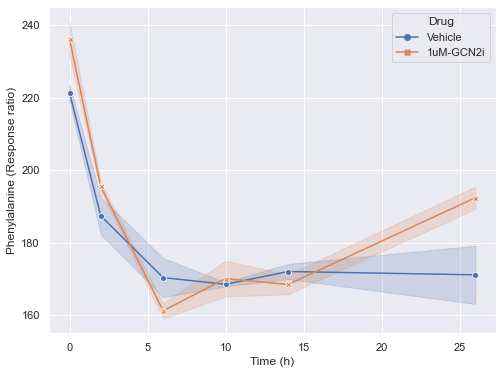

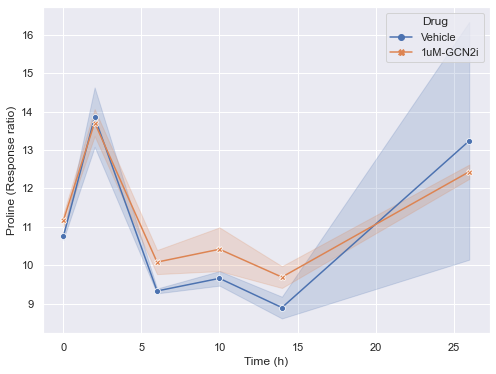

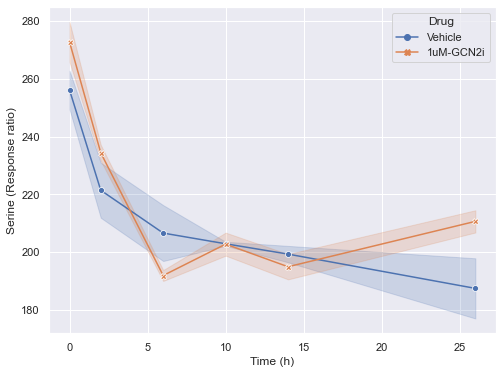

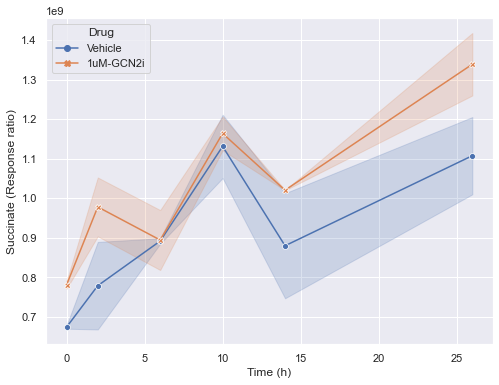

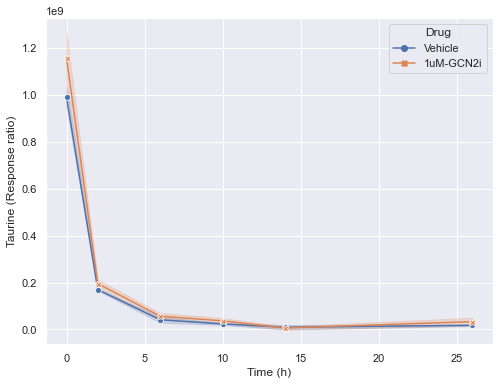

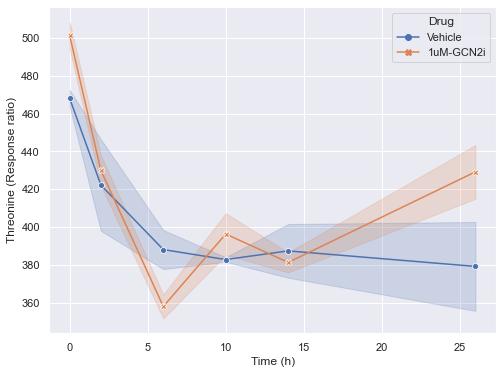

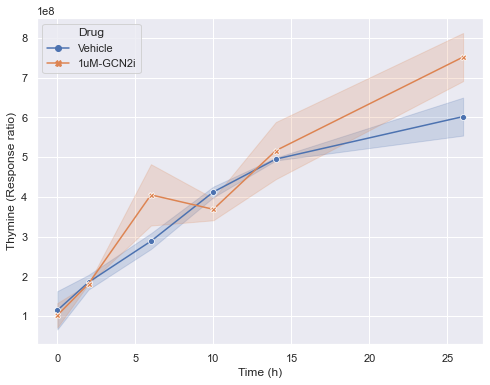

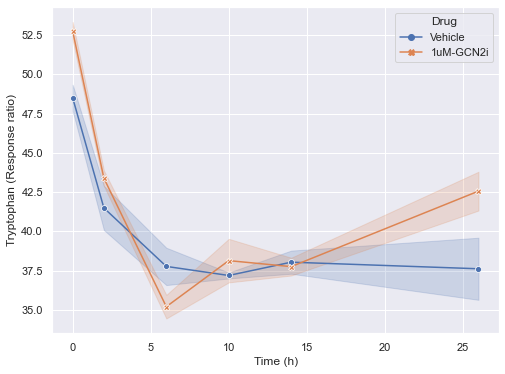

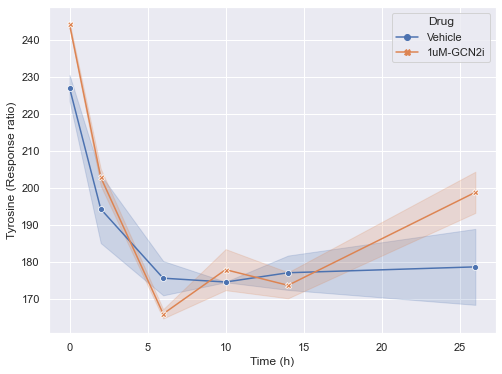

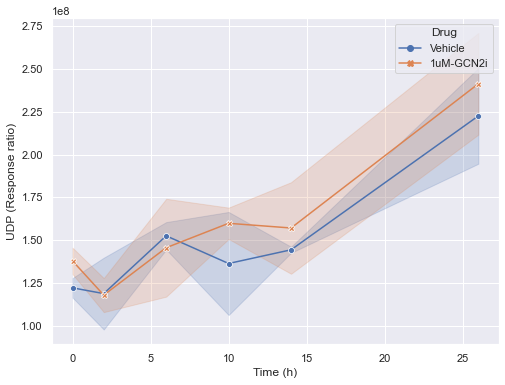

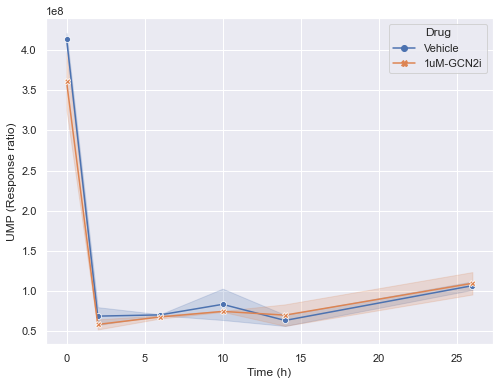

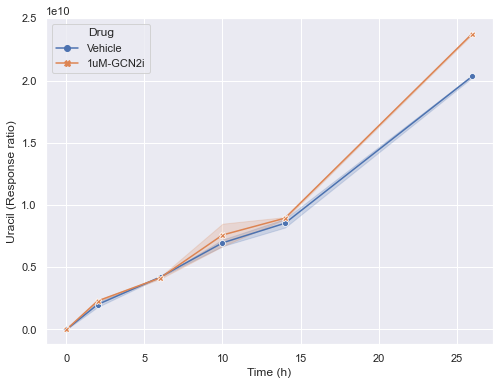

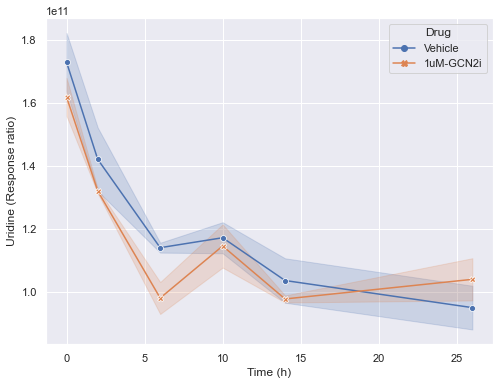

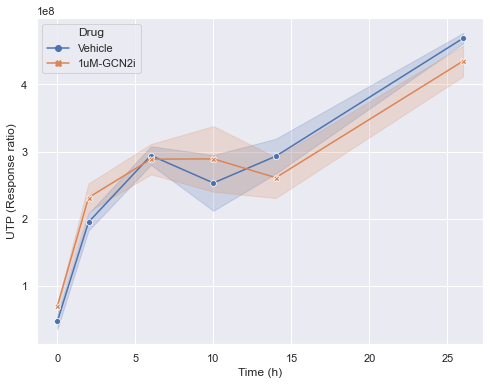

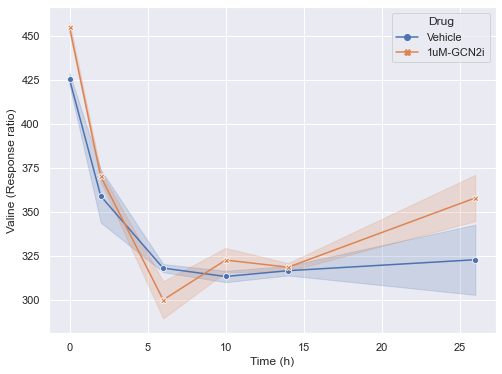

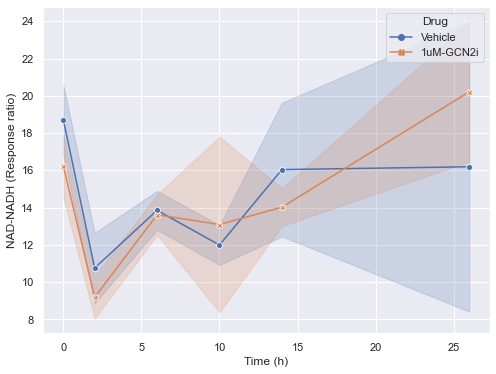

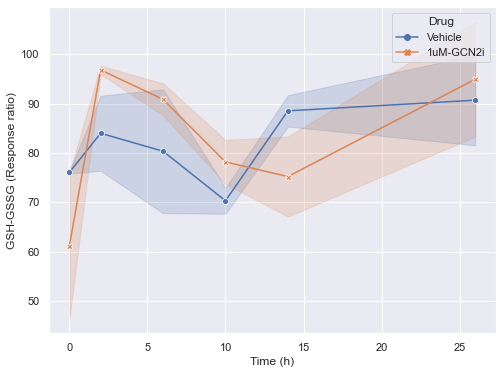

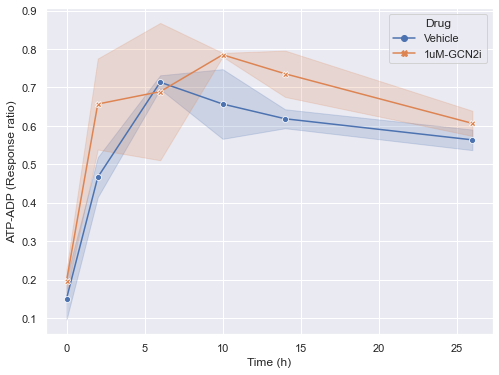

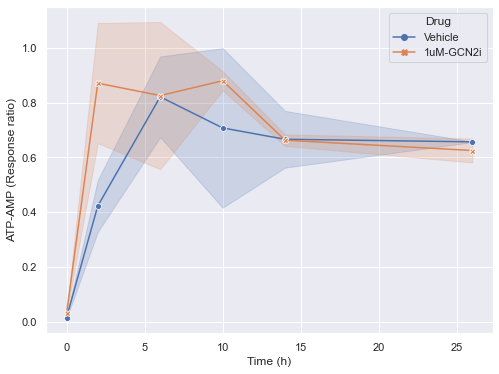

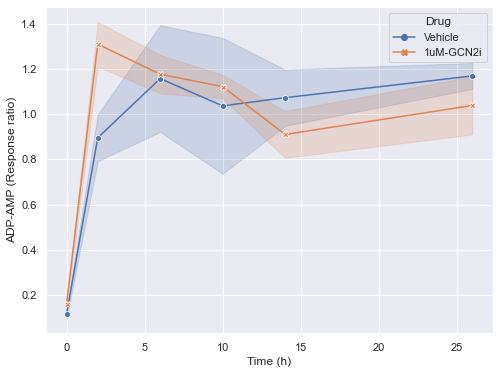

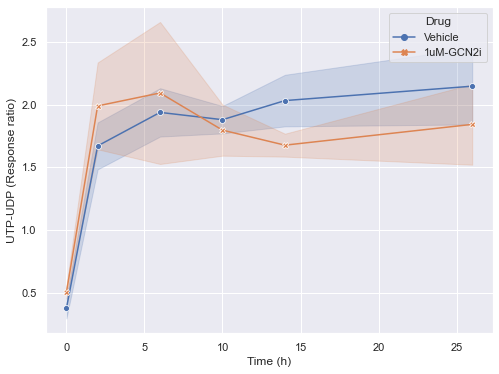

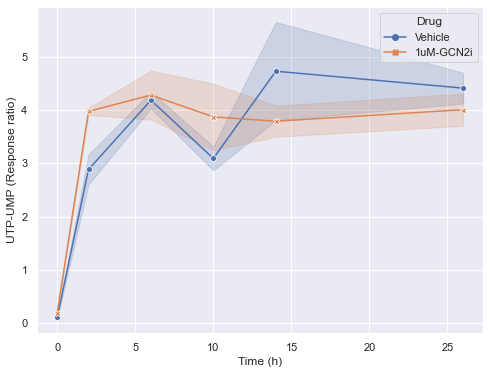

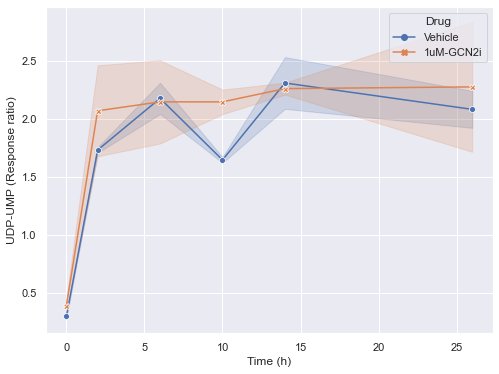

In [9]:
metab_names = df.columns.values[6:]

for mn in metab_names:
    mn_fn = mn.split()[0]
    pdf = matplotlib.backends.backend_pdf.PdfPages('metabolite_over_time/{}_vs_time.pdf'.format(mn_fn))
    fig = plt.figure(figsize=(8, 6))

    mask = (df['Sample_type'] == 'Cells')
    g = sns.lineplot(data=df[mask], x='Time', y=mn, hue='Drug',
                 style='Drug', markers=True, dashes=False)

    plt.xlabel('Time (h)', size=12);
    plt.ylabel('{} (Response ratio)'.format(mn_fn), size=12);

    pdf.savefig(fig)
    plt.show(fig)
    plt.close(fig)
    pdf.close()


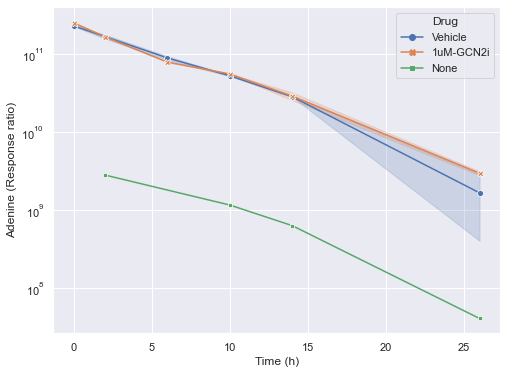

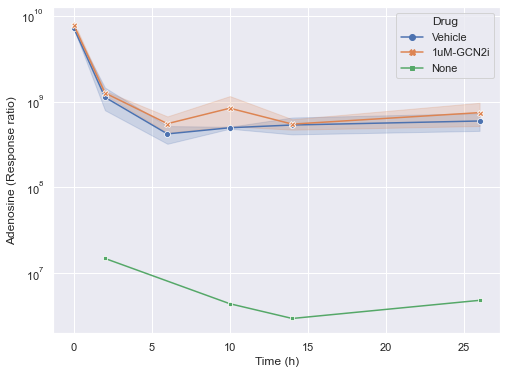

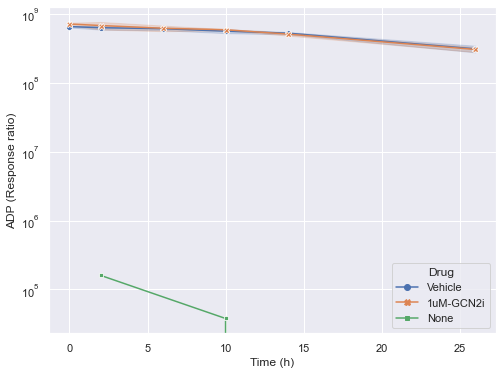

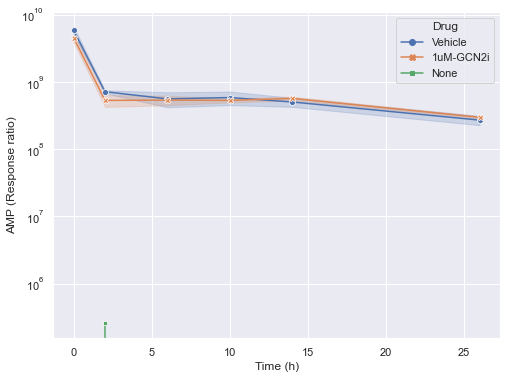

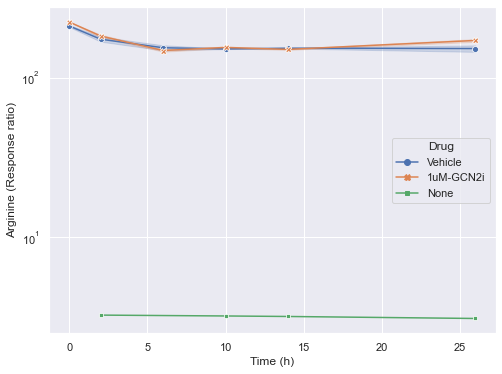

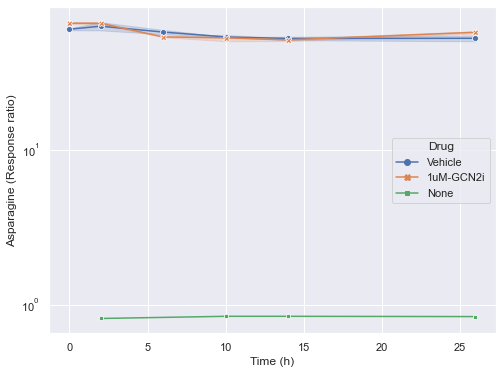

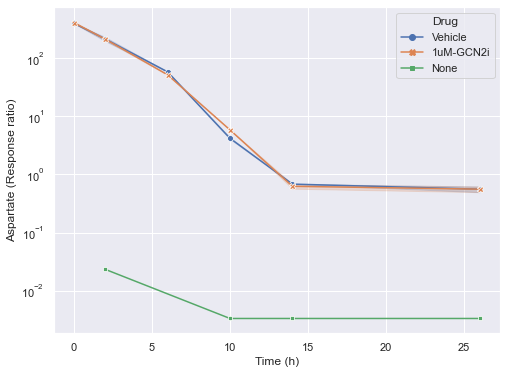

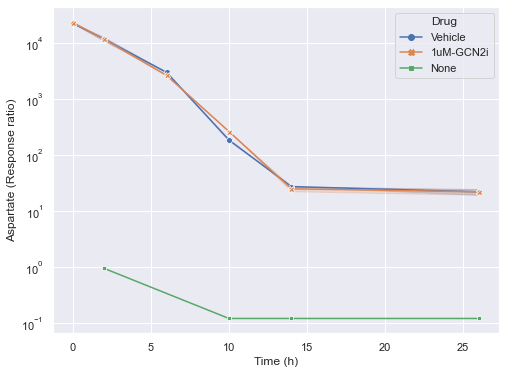

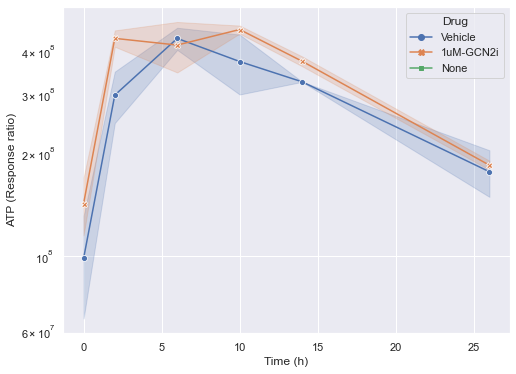

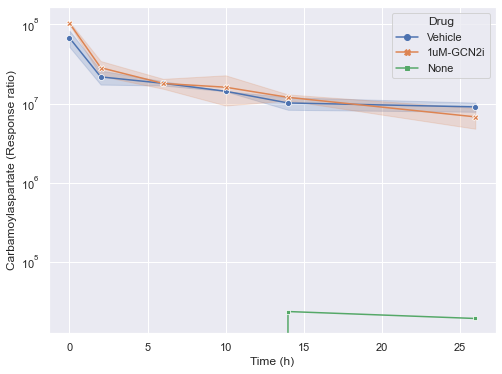

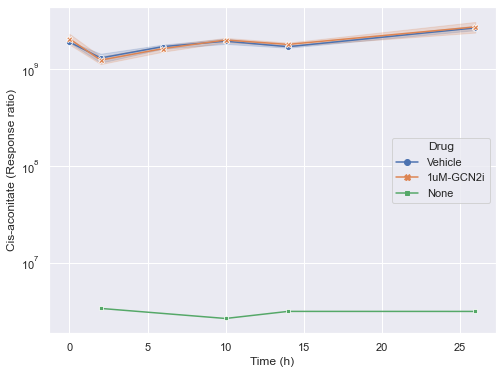

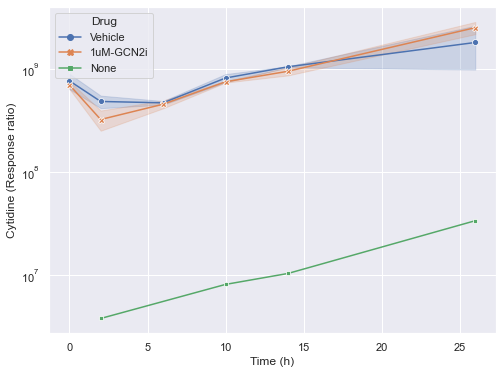

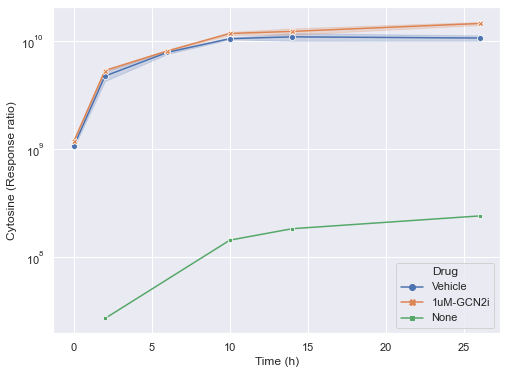

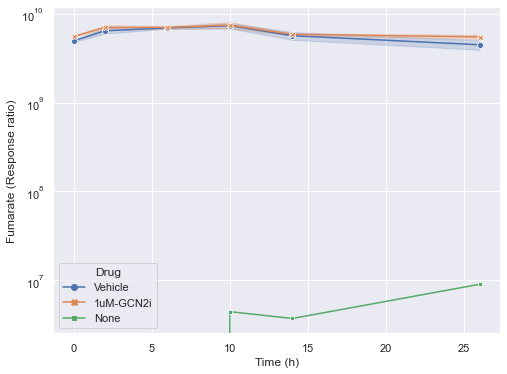

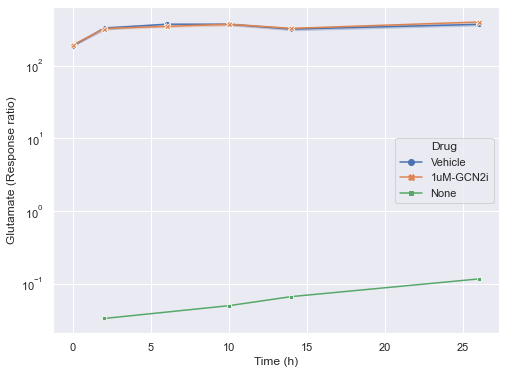

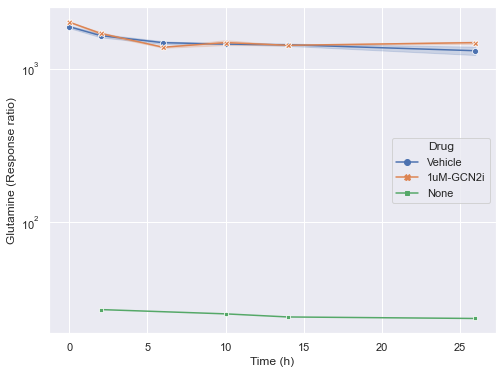

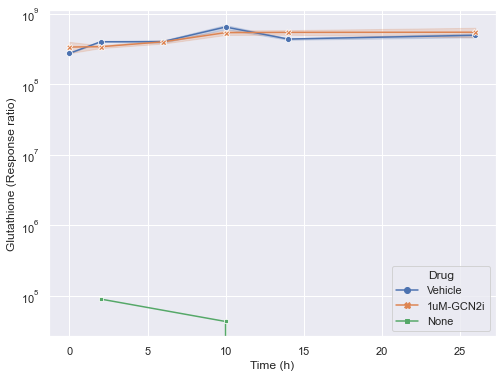

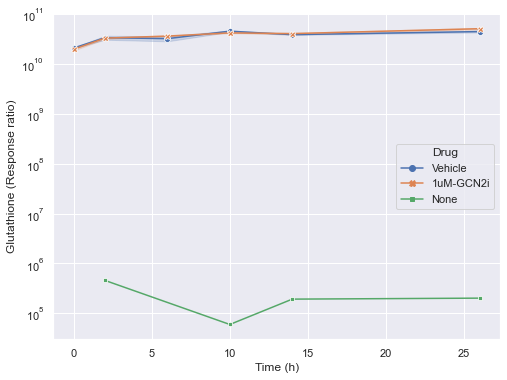

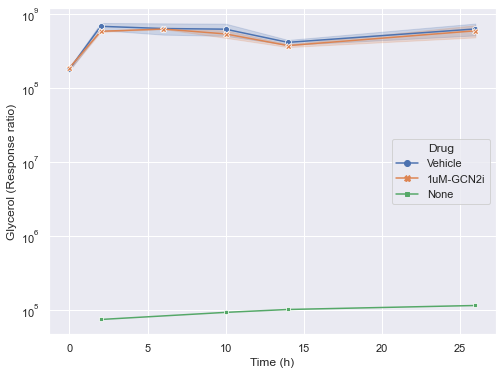

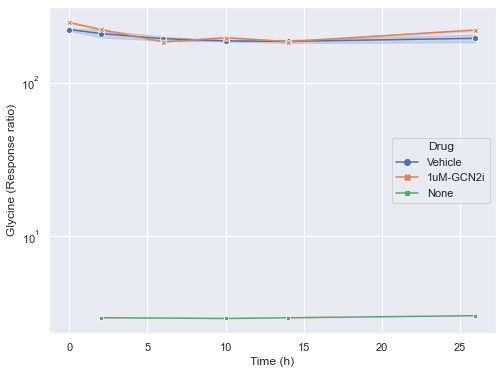

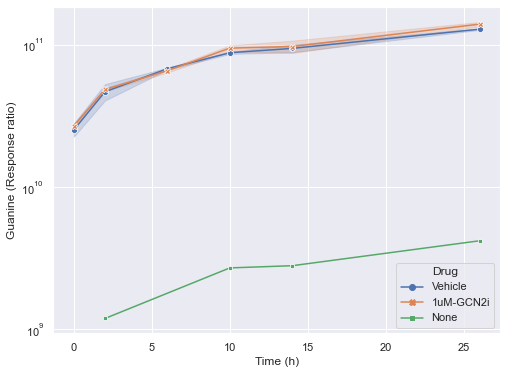

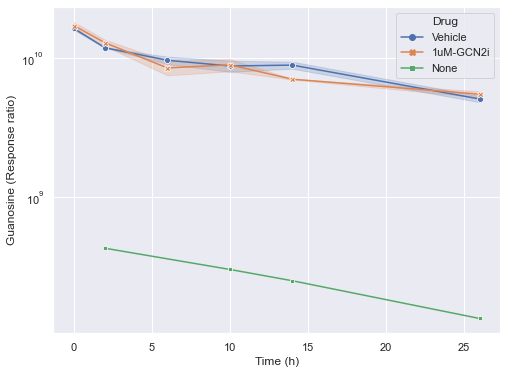

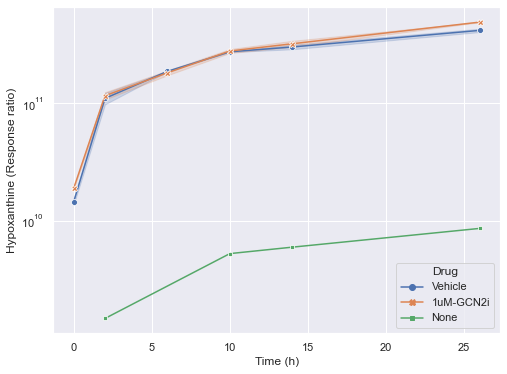

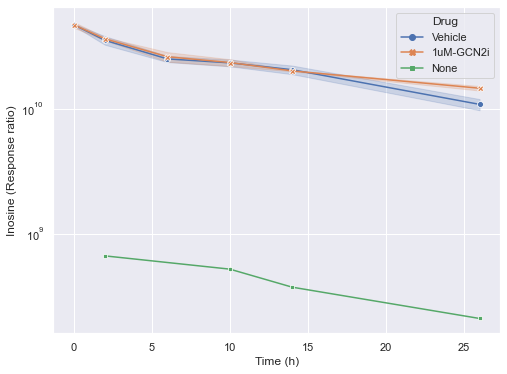

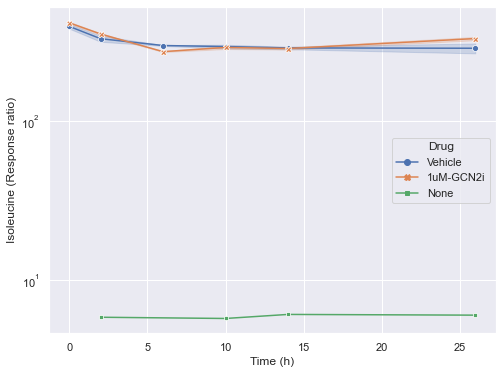

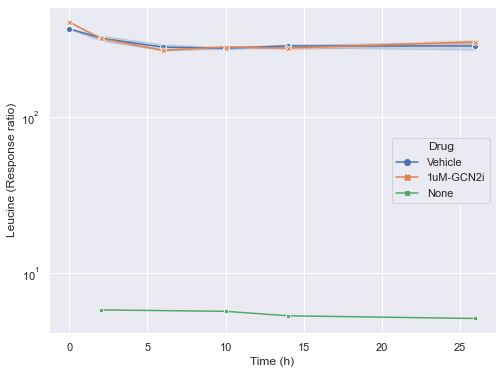

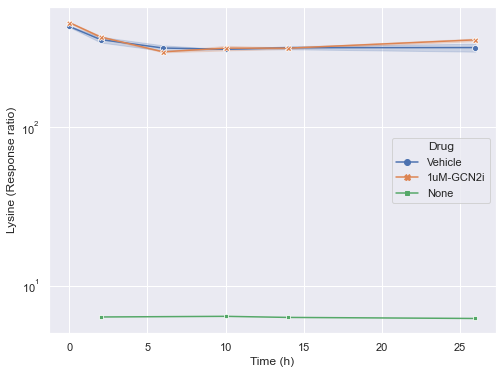

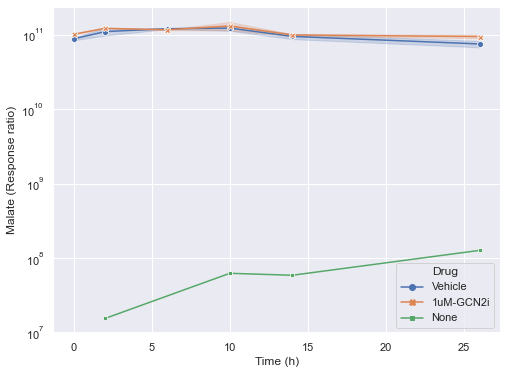

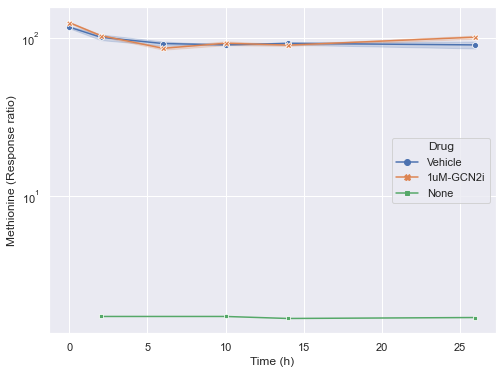

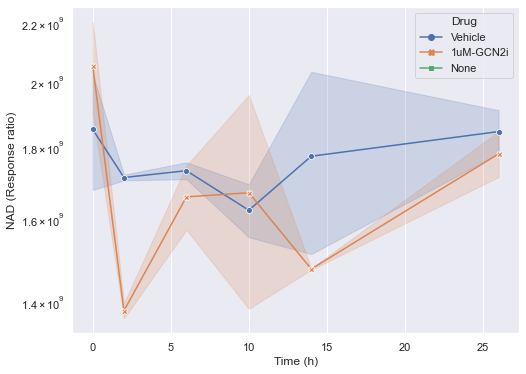

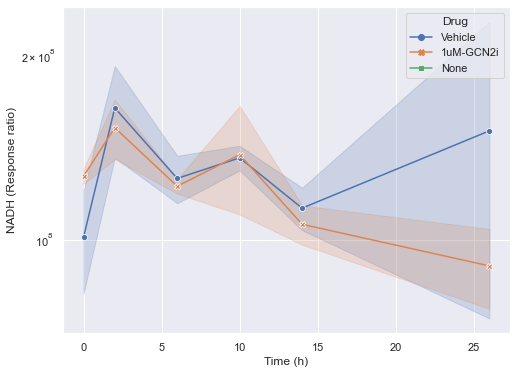

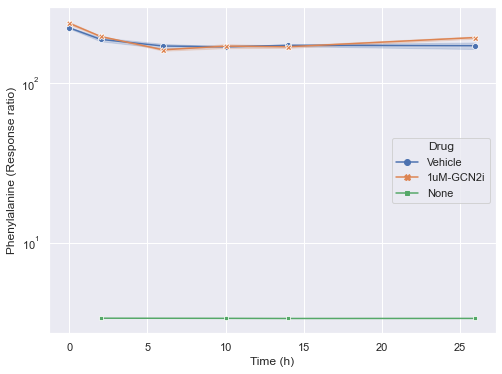

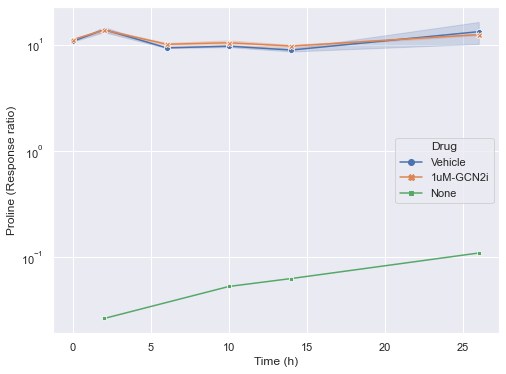

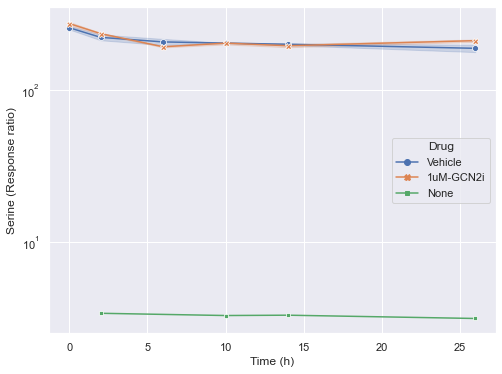

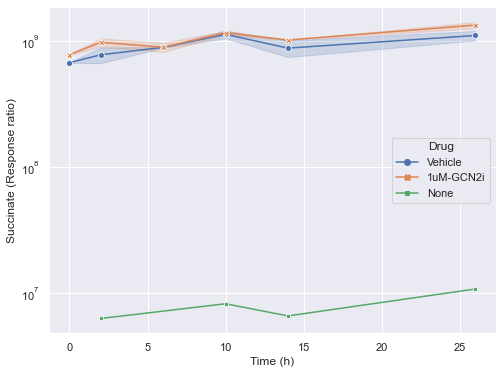

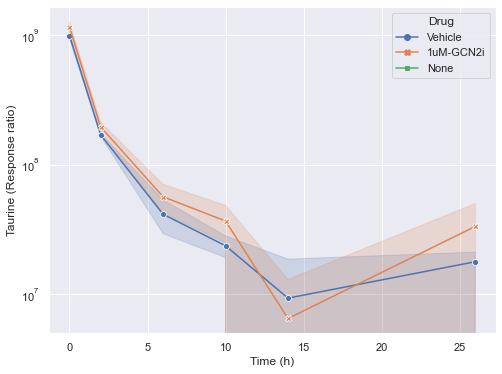

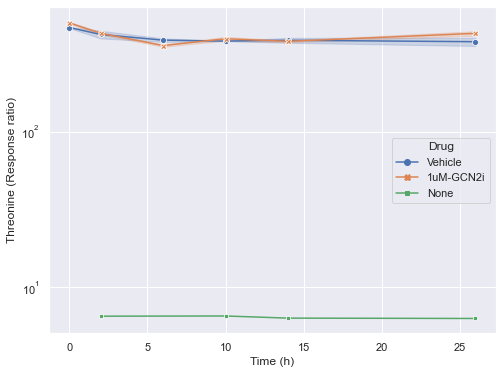

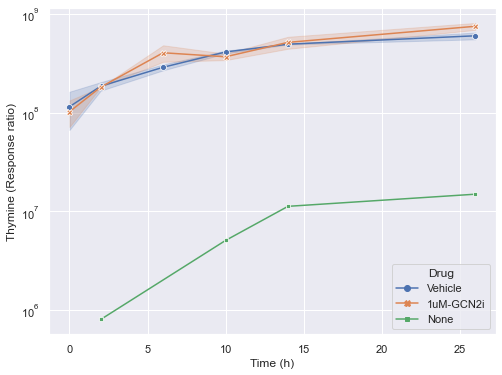

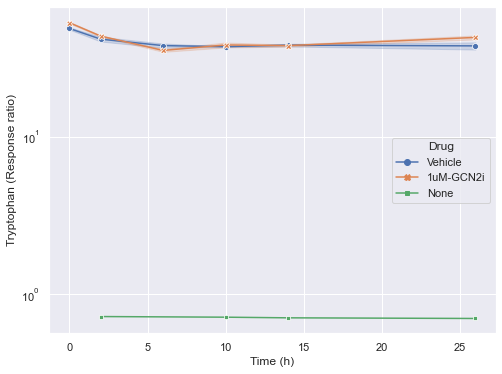

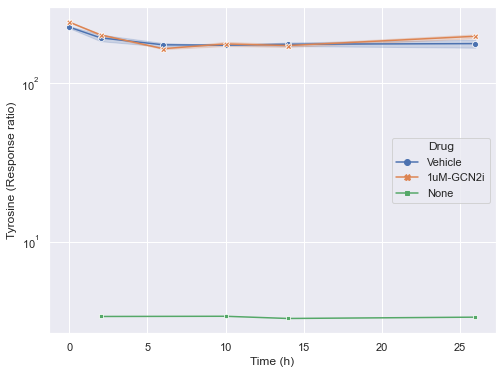

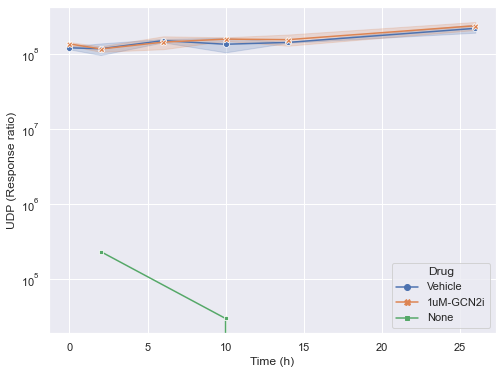

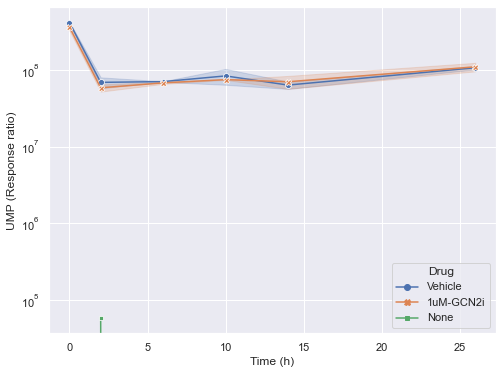

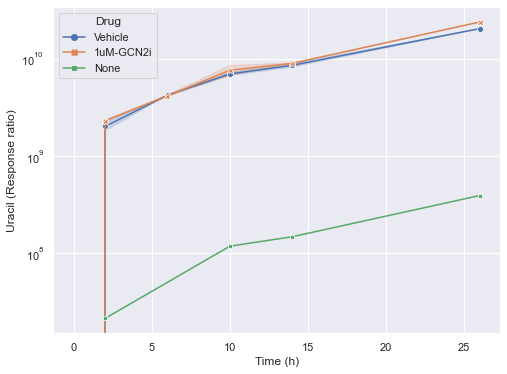

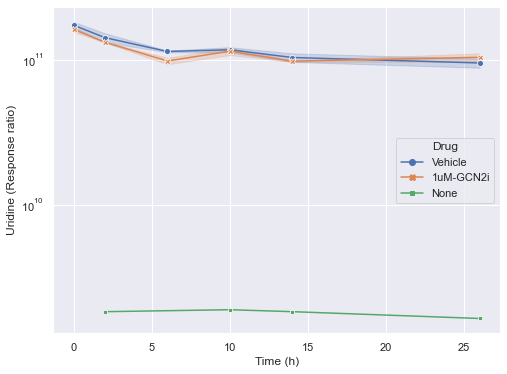

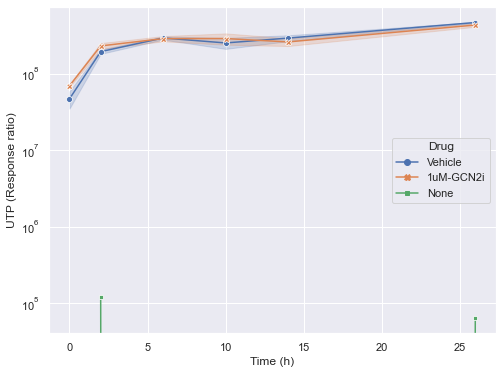

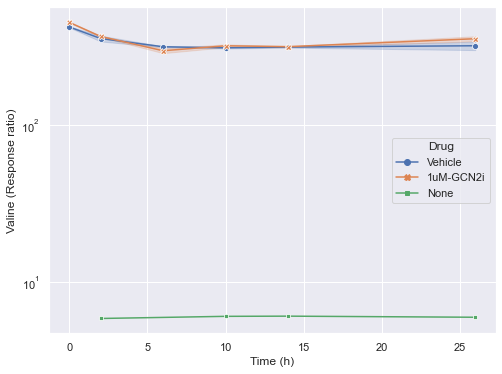

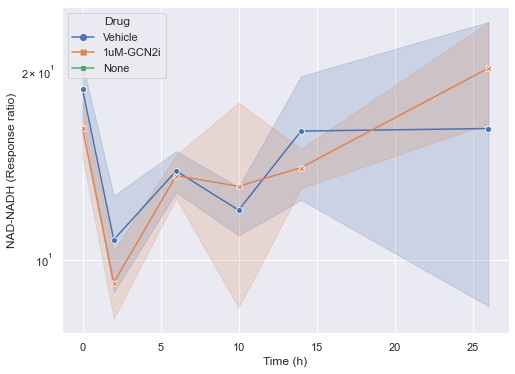

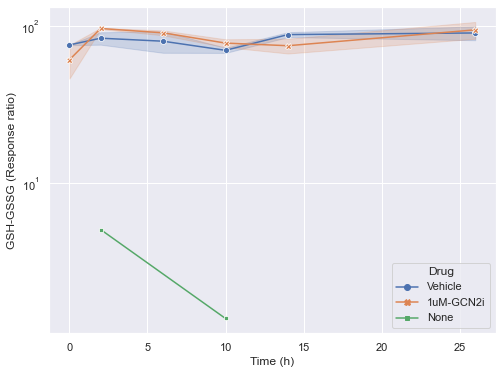

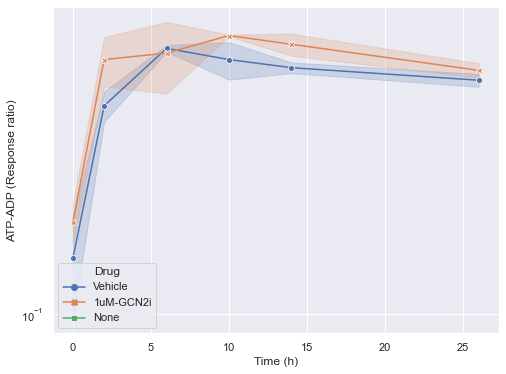

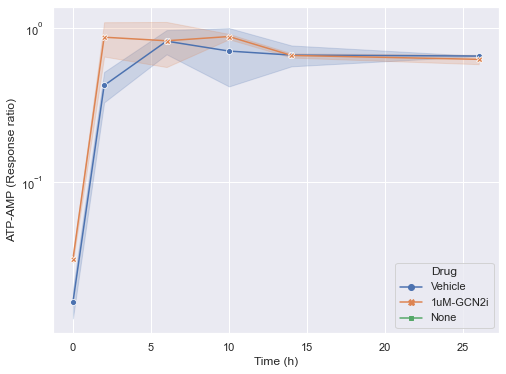

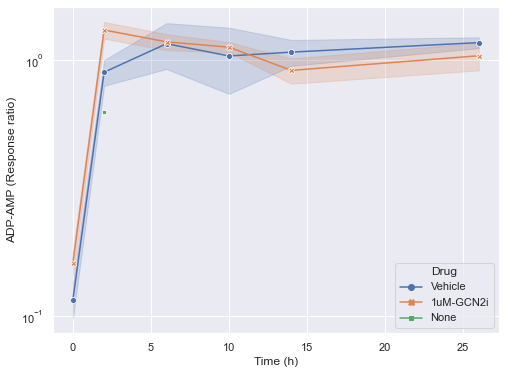

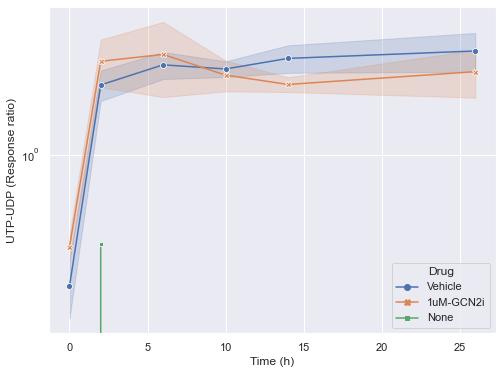

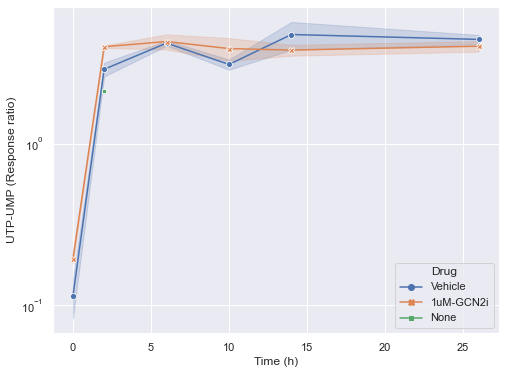

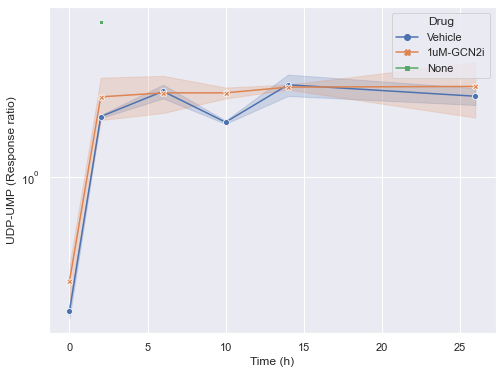

In [10]:
metab_names = df.columns.values[6:]

for mn in metab_names:
    mn_fn = mn.split()[0]
    pdf = matplotlib.backends.backend_pdf.PdfPages('metabolite_over_time_media/{}_vs_time.pdf'.format(mn_fn))
    fig = plt.figure(figsize=(8, 6))

    g = sns.lineplot(data=df, x='Time', y=mn, hue='Drug',
                 style='Drug', markers=True, dashes=False)
    g.set(yscale="log");

    plt.xlabel('Time (h)', size=12);
    plt.ylabel('{} (Response ratio)'.format(mn_fn), size=12);

    pdf.savefig(fig)
    plt.show(fig)
    plt.close(fig)
    pdf.close()


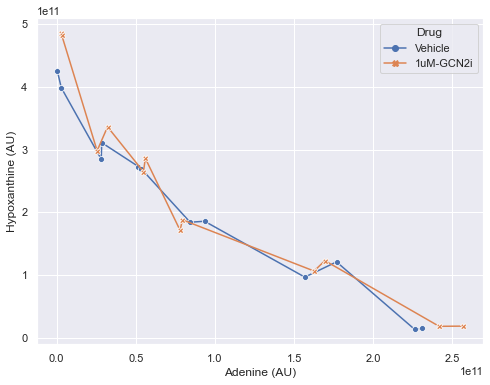

In [11]:
### Hypoxanthine as a function of Adenine ###

pdf = matplotlib.backends.backend_pdf.PdfPages('Hypoxanthin_vs_Adenine.pdf')
fig = plt.figure(figsize=(8, 6))

mask = (df['Sample_type'] == 'Cells')
g = sns.lineplot(data=df[mask], x='Adenine pos', y='Hypoxanthine pos', hue='Drug',
             style='Drug', markers=True, dashes=False)
plt.xlabel('Adenine (AU)', size=12);
plt.ylabel('Hypoxanthine (AU)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

<ipython-input-14-03af2a471ca5>:23: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=2)


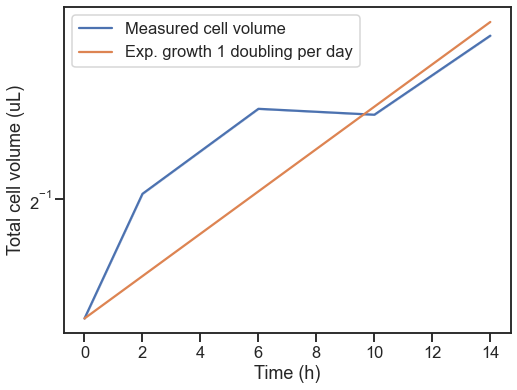

In [14]:
y0 = df[df['Time'] == 0]['Cell_vol'].values[0]
r = 1/24
def y(y0, r, t):
    return(y0*2**(r*t))

ts = np.arange(0, 15, 1)
ys = y(y0, r, ts)



### Cell volume as a function of time ###


pdf = matplotlib.backends.backend_pdf.PdfPages('CellVol_vs_time.pdf')
fig = plt.figure(figsize=(8, 6))


mask = (df['Sample_type'] == 'Cells') & (df['Time'] < 20)
g = sns.lineplot(data=df[mask], x='Time', y='Cell_vol',
             markers=True, dashes=False)
g2 = sns.lineplot(x=ts, y=ys, dashes=True)

plt.yscale('log', basey=2)

plt.xlabel('Time (h)')#, size=12);
plt.ylabel('Total cell volume (uL)')#, size=12);

plt.legend(g.lines, ['Measured cell volume', 'Exp. growth 1 doubling per day'])


pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

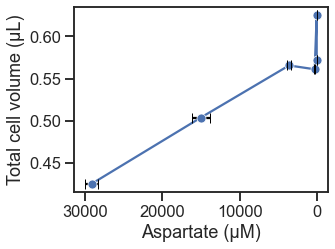

In [15]:
### Cell volume as a function of remaining Asp ###

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))

mask = (df_mean['Sample_type'] == 'Cells') & (df_mean['Time'] < 30)
g = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Cell_vol', markers=True, marker="o")
g.errorbar(x=df_mean[mask]['Aspartate conc'].values, y=df_mean[mask]['Cell_vol'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5)


g.set(xlabel='Aspartate (μM)', ylabel='Total cell volume (μL)');
g.invert_xaxis()


plt.tight_layout()
fig.savefig('AspToVol.pdf')

In [105]:
df_mean['Aspartate conc depl'] = np.abs(df_mean['Aspartate conc'] - df_mean['Aspartate conc'].values[0])

In [106]:
df_mean['Aspartate conc depl']

0        0.000000
1    14130.106328
2    29133.319815
3    25530.491667
4    28848.167691
5    29134.376391
6    29101.072329
7    29134.376391
8    29106.348515
9    29134.376391
Name: Aspartate conc depl, dtype: float64

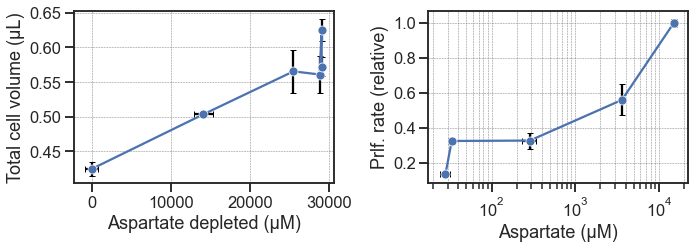

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.8))

mask = (df['Sample_type'] == 'Cells')
mask = (df_mean['Sample_type'] == 'Cells') & (df_mean['Time'] < 30)
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc depl', y='Cell_vol', markers=True, marker="o", zorder=11)
g1.errorbar(x=df_mean[mask]['Aspartate conc depl'].values, y=df_mean[mask]['Cell_vol'].values, xerr=df_stdev[mask]['Aspartate conc'].values, yerr=df_mean[mask]['Cell_vol_stdev'].values, fmt='none', color='black', capsize=3, zorder=10)


g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g1.set(xlabel='Aspartate depleted (μM)', ylabel='Total cell volume (μL)');
#g1.invert_xaxis()
#g1.set_xticklabels([999, 30000, 20000, 10000, 0])


g2 = sns.lineplot(ax=ax2, x=df_mean[mask]['Aspartate conc'].values[1:], y=df_mean[mask]['prof'].values[1:], markers=True, marker="o", zorder=11)
g2.set(xlabel='Aspartate (μM)', ylabel='Prlf. rate (relative)');
g2.errorbar(x=df_mean[mask]['Aspartate conc'].values[1:], y=df_mean[mask]['prof'].values[1:], xerr=df_stdev[mask]['Aspartate conc'].values[1:], yerr=df_stdev[mask]['prof'].values[1:], fmt='none', color='black', capsize=3, zorder=10)
#g2.invert_xaxis()
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g2.set(xscale="log");


plt.tight_layout()
fig.savefig('combined_plots_AspToVol-Asp_proff.pdf')